# Methode 1: Convex Hull Hand Gesture Recognition

The implementation in this notebook allows the counting of raised fingers of a hand. For this purpose, the Convex Hull algorithm is used.

This notebook serves as a test and starting point for implementing hand gesture recognition via a live camera.

In [47]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Loading the data

For the tests I created my own small data set.

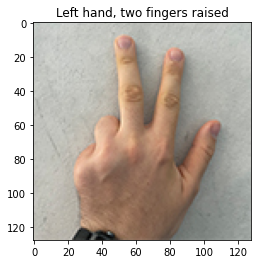

In [48]:
image_path = 'data/hands_128/hand_128_3L.jpg'
image = cv2.imread(image_path)
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

number_of_fingers = int(image_path[-6])

def show_in_notebook(image_to_draw, title):
    """
    The following code is only used to display the image in Jupyter Notebook.
    """
    plt.imshow(image_to_draw)
    plt.title(title)
    plt.show()
    
show_in_notebook(image_RGB, 'Left hand, two fingers raised')

## Extracting the hand from the image

In the next cell, we extract the hand from the image with the help of color filters. This way, we can define a contour that we will need later to draw the hull.

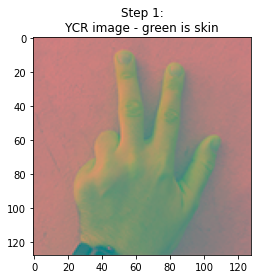

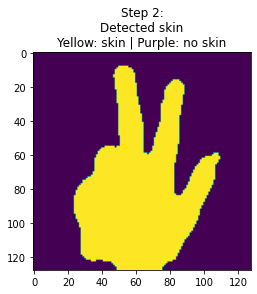

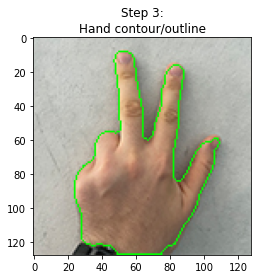

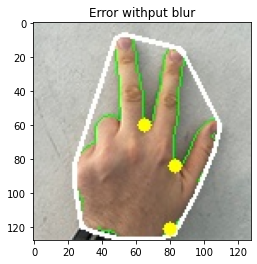

In [49]:
image_YCR = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)

show_in_notebook(image_YCR, 'Step 1:\nYCR image - green is skin')

# We determined the color range via trial and error. 
# Unfortunately, this method does not work well on backgrounds with light skin-like color 
# or hands with darker skin colors. 
# Therefore, it may be necessary to use a different method in a real-life scenario.
darkest_skin_color_YCR = np.array([0,138,80], np.uint8)
lightest_skin_colour_YCR = np.array([231,160,124], np.uint8)
detected_skin = cv2.inRange(image_YCR, darkest_skin_color_YCR, lightest_skin_colour_YCR)

image_blurred = cv2.blur(detected_skin, (5,5))
_, detected_skin = cv2.threshold(image_blurred, 138, 160, cv2.THRESH_BINARY)

show_in_notebook(detected_skin, 'Step 2:\nDetected skin\nYellow: skin | Purple: no skin')

contours, hierarchy = cv2.findContours(detected_skin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
hand_contour = max(contours, key=lambda x: cv2.contourArea(x))
cv2.drawContours(image_RGB, [hand_contour], -1, (0,255,0), 1)

show_in_notebook(image_RGB, 'Step 3:\nHand contour/outline')

# Without the blur, there could be errors. See error image.
error_image = cv2.cvtColor(cv2.imread('docs/output/hull_error_without_blur.jpg'), cv2.COLOR_BGR2RGB)
show_in_notebook(error_image, 'Error withput blur')

## Drawing the hull and calculate the defects

In this approach, the outline of the hand was extracted from the image. An envelope (hull) was drawn that encloses the outline of the hand in the smallest possible way.

**The implementation in the notebook detects the hand via the (skin) color. This method is not applicable because skin colors differ significantly between people. The implementation of the ML approach shows a better extraction of the hand.**

Severe deviations of the hand contour from the hull are defined as *convexity defects* and describe the gaps between the raised fingers, as shown in the following figure.

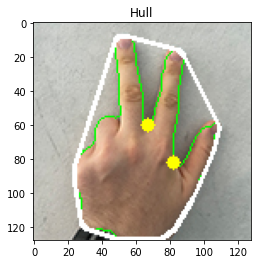

The numbers of raised finger is 3 and that is True!


In [50]:
hull = cv2.convexHull(hand_contour)
cv2.drawContours(image_RGB, [hull], -1, (255,255,255), 2)

hull = cv2.convexHull(hand_contour, returnPoints=False)
defects = cv2.convexityDefects(hand_contour, hull)

count = 0
if defects is not None:
    for i in range(defects.shape[0]):
        (s, e, f, d) = defects[i][0]
        start = tuple(hand_contour[s][0])
        end = tuple(hand_contour[e][0])
        far = tuple(hand_contour[f][0])
        a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
        c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
        angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))
        if angle <= np.pi / 2:
            count += 1
            cv2.circle(image_RGB, far, 4, [255, 255, 0], -1)
    if count > 0:
        count += 1

show_in_notebook(image_RGB, 'Hull')
success = cnt == number_of_fingers
print(f'The numbers of raised finger is {cnt} and that is {success}!')

In [51]:
# Save image in output directory
cv2.imwrite(f'data/output/{image_path.split("/")[-1][:-4]}_{success}.jpg', cv2.cvtColor(image_RGB, cv2.COLOR_BGR2RGB))

True

## Successes

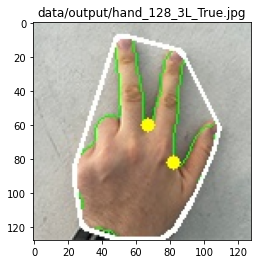

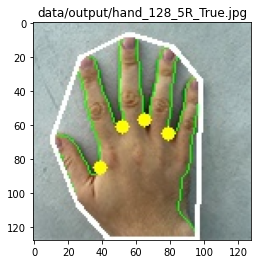

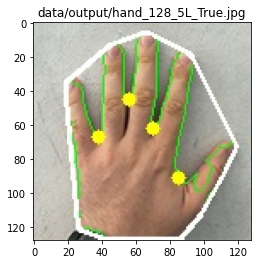

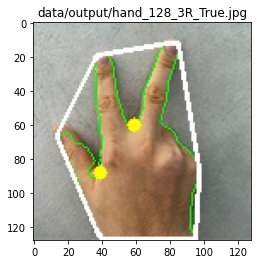

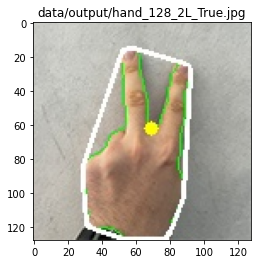

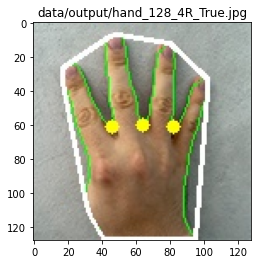

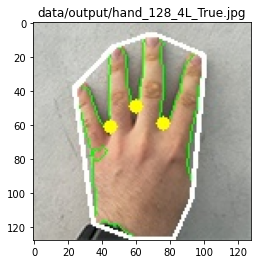

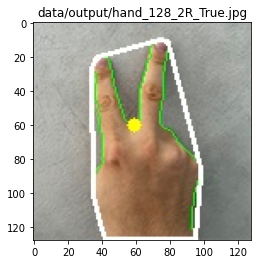

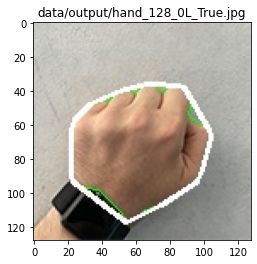

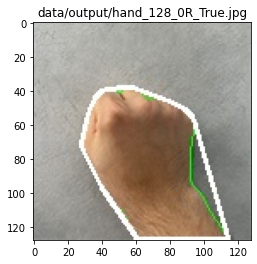

In [52]:
import glob
success_images_paths = glob.glob(f'docs/output/hand_128_*_True.jpg')
for success_image_path in success_images_paths:
    success_image = cv2.imread(success_image_path)
    show_in_notebook(cv2.cvtColor(success_image, cv2.COLOR_BGR2RGB), success_image_path)

## Failures

The applied method cannot distinguish between a single raised finger and no raised finger. In both cases, there are no defects that are required to determine the number of fingers.

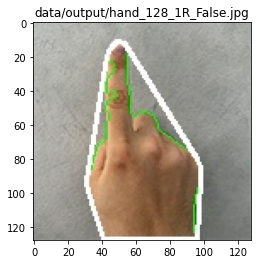

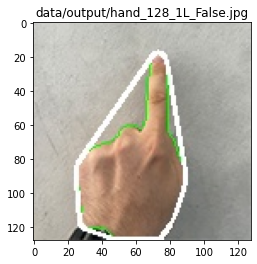

In [53]:
error_images_paths = glob.glob(f'docs/output/hand_128_*_False.jpg')
for error_image_path in error_images_paths:
    error_image = cv2.imread(error_image_path)
    show_in_notebook(cv2.cvtColor(error_image, cv2.COLOR_BGR2RGB), error_image_path)